<a href="https://colab.research.google.com/github/Mo-Bkny/python/blob/master/Word_cloud_claims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google.colab import files
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download VADER lexicon
nltk.download('vader_lexicon')

# Upload the file
uploaded = files.upload()

# Assuming the uploaded file is named 'filtered_spreadsheet.xlsx'
file_name = list(uploaded.keys())[0]

# Load the uploaded file into a DataFrame
df = pd.read_excel(file_name)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Saving Claims raw data.xlsx to Claims raw data.xlsx


In [3]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['Free Response[sms]'], inplace=True)
df.dropna(subset=['Free Response[sms]'], inplace=True)

# Filter out rows where 'Free Response[sms]' contains 'skipped'
df_filtered = df[~df['Free Response[sms]'].str.contains('skipped', case=False, na=False)]

# Combine all feedback into a single string
feedback_text = df_filtered['Free Response[sms]'].dropna().tolist()
feedback_combined = ' '.join(feedback_text)

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment for each feedback comment
df_filtered['sentiment'] = df_filtered['Free Response[sms]'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)

# Classify comments as positive, negative, or neutral
df_filtered['sentiment_label'] = df_filtered['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


<ipython-input-3-32ad331728d9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['Free Response[sms]'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
<ipython-input-3-32ad331728d9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment_label'] = df_filtered['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


In [12]:
from collections import Counter
import re

# Function to extract words from text
def extract_words(text):
    if isinstance(text, str): # Check if text is a string
        words = re.findall(r'\b\w+\b', text.lower())
        return words
    else: # Return empty list if text is not a string
        return []

# Words to exclude
exclude_words = {'skipped', 'the', 'and', 'to', 'is', 'it', 'this', 'that', 'i', 'claim', 'a',
                 'my', 'with', 'for', 'of', 'on','be', 'very', 'from', 'on', 'have', 'not', 'in', 'all', 'am', 'you', 'no', 'me', 'months', 'days', 'years', 'at', 'were', 'momentum', 'via', 'etc', 'must', 'add', 'want', 'make', 'one', 'e', 'get', 'can', 'see', 'go', 'so','seem', 'also', 'n', 'momentums', 'eis', 'we', 'would', 'would', 'our', 'ours', 'yours', 'your', 'yourselves','its',
                 'their', 'them', 'themselves', 'there', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is','are', 'was', 'were', 'be', 'been', 'being', 'got', 'bit', 'have', 'has', 'sort', 'had', 'do', 'does', 'did','added', 'some', 'don', 'sure', 'other', 'far', '6', 'went', 'place', 'please', 'anne', 'done', '1st', '50', 'first', 'never',
                 'as', 'u', 'but', 'same', 'if', 'there', 'there', 'out', 'up', 'an', 'more', 'only', 'took', 'didn', 'cannot', 'however', 'again', 'going', '2023', '20', 'van', 'within', 'monthly', '5', 'use', 'fully','6', '50 ',                 'doing', 'many','entire', 'every', 'any', 'both', 'each', 'when', 'where', 'may', 'according', 'even', 'come', 'much', 'how', 'something','say', 'nie', 'turn', 'find', 'side', 'few', 'very', 'none', 'given', 'can', 'im', 'that', 'this', 'these', 'those','being', 'way', '10', 'or', 't', 'could', 'will', 'thank', 'through', 's', 'than', 'keep', 'claims', 'claim','after',
                 'sent', 'came', 'like', 'then', 'just', 'two', 'they', 'forward', 'without', 'now', 'whole', 'before', 'long', 'need', 'once', 'give', 'due', 'he', 'everything', 'year', 'days', 'day','m', 'well', 'day', 'over', 'back', 'by', '1', '2', '3', 'made', 'ask', 'into', 'dont', 'period', 'broker', 'client' , 'his', 'huge', 'number','amount', '100', 'mr', 'bills', 'always', 'mail', 'about'}

# Add a new column to store the original index
for index, row in df_filtered.iterrows():
    df_filtered.loc[index, 'original_index'] = index

# Extract words from positive and negative comments
positive_words = {}
negative_words = {}

for index, row in df_filtered.iterrows():
    words = extract_words(row['Free Response[sms]'])
    words = [word for word in words if word not in exclude_words]
    if row['sentiment_label'] == 'positive':
        for word in words:
            if word not in positive_words:
                positive_words[word] = {'count': 0, 'original_index': []}
            positive_words[word]['count'] += 1
            positive_words[word]['original_index'].append(row['original_index'])
    elif row['sentiment_label'] == 'negative':
        for word in words:
            if word not in negative_words:
                negative_words[word] = {'count': 0, 'original_index': []}
            negative_words[word]['count'] += 1
            negative_words[word]['original_index'].append(row['original_index'])

# Convert the dictionaries to DataFrames
positive_words_df = pd.DataFrame([(word, data['count'], data['original_index']) for word, data in positive_words.items()], columns=['word', 'count', 'original_index'])
negative_words_df = pd.DataFrame([(word, data['count'], data['original_index']) for word, data in negative_words.items()], columns=['word', 'count', 'original_index'])


In [13]:
#print("Positive Words:")
#print(positive_words_df.head(20))

#print("\nNegative Words:")
#print(negative_words_df.head(20))

# Add a new column to store the original index
for index, row in df_filtered.iterrows():
    df_filtered.loc[index, 'original_index'] = index

# Extract words from positive and negative comments
positive_words = {}
negative_words = {}

for index, row in df_filtered.iterrows():
    words = extract_words(row['Free Response[sms]'])
    words = [word for word in words if word not in exclude_words]
    if row['sentiment_label'] == 'positive':
        for word in words:
            if word not in positive_words:
                positive_words[word] = {'count': 0, 'original_index': []}
            positive_words[word]['count'] += 1
            positive_words[word]['original_index'].append(row['original_index'])
    elif row['sentiment_label'] == 'negative':
        for word in words:
            if word not in negative_words:
                negative_words[word] = {'count': 0, 'original_index': []}
            negative_words[word]['count'] += 1
            negative_words[word]['original_index'].append(row['original_index'])

# Convert the dictionaries to DataFrames
positive_words_df = pd.DataFrame([(word, data['count'], data['original_index']) for word, data in positive_words.items()], columns=['word', 'count', 'original_index'])
negative_words_df = pd.DataFrame([(word, data['count'], data['original_index']) for word, data in negative_words.items()], columns=['word', 'count', 'original_index'])


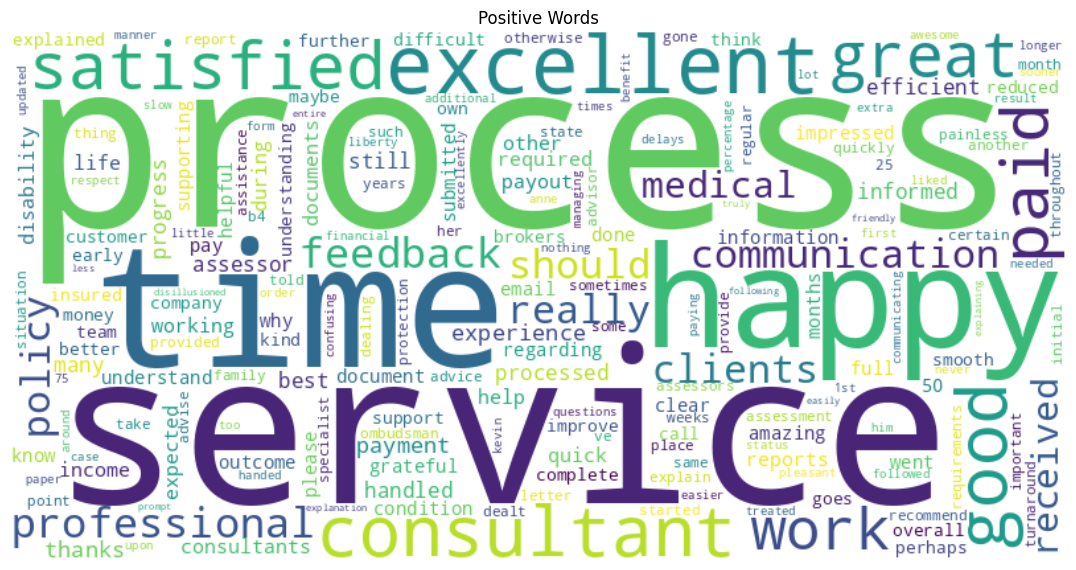

In [14]:
# Create the positive wordcloud
plt.figure(figsize=(30, 15))
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies({k: v['count'] for k, v in positive_words.items()}) # Changed this line to pass a dictionary with word counts
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Words')
plt.axis('off')
plt.show()


In [16]:
#Find the word 'process' in the positve_words/negative_words dictionary
if 'process' in negative_words:
  original_indices = positive_words['process']['original_index']

  # Print the sentences containing 'process' separated by newlines
  for index in set(original_indices):
    print(df_filtered.loc[index, 'Free Response[sms]'] + '\n')

We handed in two claims a the same time. It would be easier if one consultant handled both. We would have liked a little bit more feedback during the process. We saw the payment in the bank account and then the letter of confirmation. It would be nicer if we were informed sooner where the process is at.

Thank you so much  I'm so grateful. The most difficult part of the process was the struggle to obtain the reports from the medical service providers.

I am very grateful to Momentum and my own brokers.  You have really helped me.  The pay out was slow  but I do understand that there is a process to complete.

Overall  I am really happy. The process was really simple and smooth. There were no issues and the team was happy to assist.

Ensure that the claims process is made very clear when a claim is lodged.

Communicate better with your customers during the process. I will make a huge difference

My experience was made much more seamless  as a result of my advisor Saville Saharan  who ex

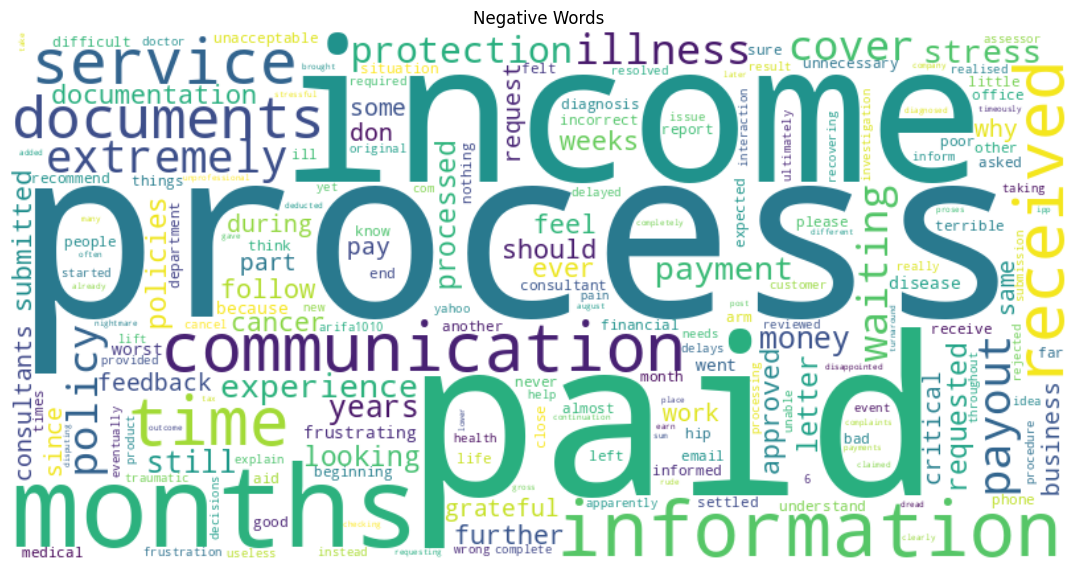

In [15]:
# Create Negative word clouds
plt.figure(figsize=(30, 15))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies({k: v['count'] for k, v in negative_words.items()})
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Words')
plt.axis('off')
plt.show()


In [10]:
# Find the word 'process' in the negative_words dictionary
if 'process' in negative_words:
  original_indices = negative_words['process']['original_index']

  # Print the sentences containing 'process' separated by newlines
  for index in set(original_indices):
    print(df_filtered.loc[index, 'Free Response[sms]'] + '\n')


My claim was delayed due to incorrect information provided by my doctor to Ampath.  As a result there were inconsistencies with the information your assessor reviewed and this caused substantial delays.  It is totally understandable that you have to verify all information  however the issue with the inconsistent information was not communicated to me.  If it was  I could have intervened to have it resolved much sooner.  It was only when I expressed my frustration with the delay in the processing of the claim to my broker and he started making enquiries  that we realised what the problem was.  I received very little communication throughout the process and even when the claim was eventually approved  I only realised that it was approved when the payment was made into my bank account.  I am very grateful for the payment of the claim  but the process was extremely frustrating.

Had to resend the same documents over and over again because you kept requesting it and saying thats why the cla